# Latent Space Manipulation using Variational Autoencoders

Variational Autoencoders (VAEs) are mainly seen as generative models. The truth is that they are capable of generating new samples, but because of the approximate posterior distrubtion form assumption, new samples often have blurriness. The truth is that nowadays advanced VAE aequitectures, GANs and diffusion models control the image generative paradigm. 

Standard VAEs and some derived but simple models like $\beta$-VAEs are sometimes used as a complement for diffusion models to learn a compact latent space which represents the most simple but sometimes crucial to model details in images. The diffusion model does the majority of work but VAEs are important for those final details. An example of this might be face generation, where a well trained VAE with enough capacity is able to learn facial features such as smiles, hair color, etc. in its latent space and then change this tiny details at a high resolution.

In this notebook we will explore this task for which VAEs can be crucial using the CelebA dataset. Once we train our model on it, we will try to interpolate the latent space to get directions for changing smiles, hair tones and more facial features.

### LOADING AND TRAINING

First we will import some libraries and dependencies

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import pandas as pd
from src.model import VAE
from src.utils import load_celeba, visualize_celeba_examples, denormalize, image_reconstruction, latent_interpolation
from src.configs import celeba_configs
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

For this aplication is crucial to use CUDA. The dataset is so big that not using a Nvidia GPU power would lead to many hours of training.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


We will be using around $200.000$ images of faces with a $128 \times 128$ resolution for training and $1.000$ for testing. The dataset CelebA is included in `torch.utils.data.datasets` but somehow I kept getting errors when trying to load it. That is why the dataset and its loader are defined in `src/utils.py`. I applied the following transformations to this dataset images:

- `transforms.Resize()` in order to get a $128 x 128$ pixels homogenous dataset.
- `transforms.CenterCrop()`
- `transforms.ToTensor()`
- `transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))` to normalize the inputs to $[-1, 1]$. The 3 dimensions are because of the 3 RGB channels.

In [4]:
root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba"
celeba_loader = load_celeba(root)

Now we can visualize some training samples:

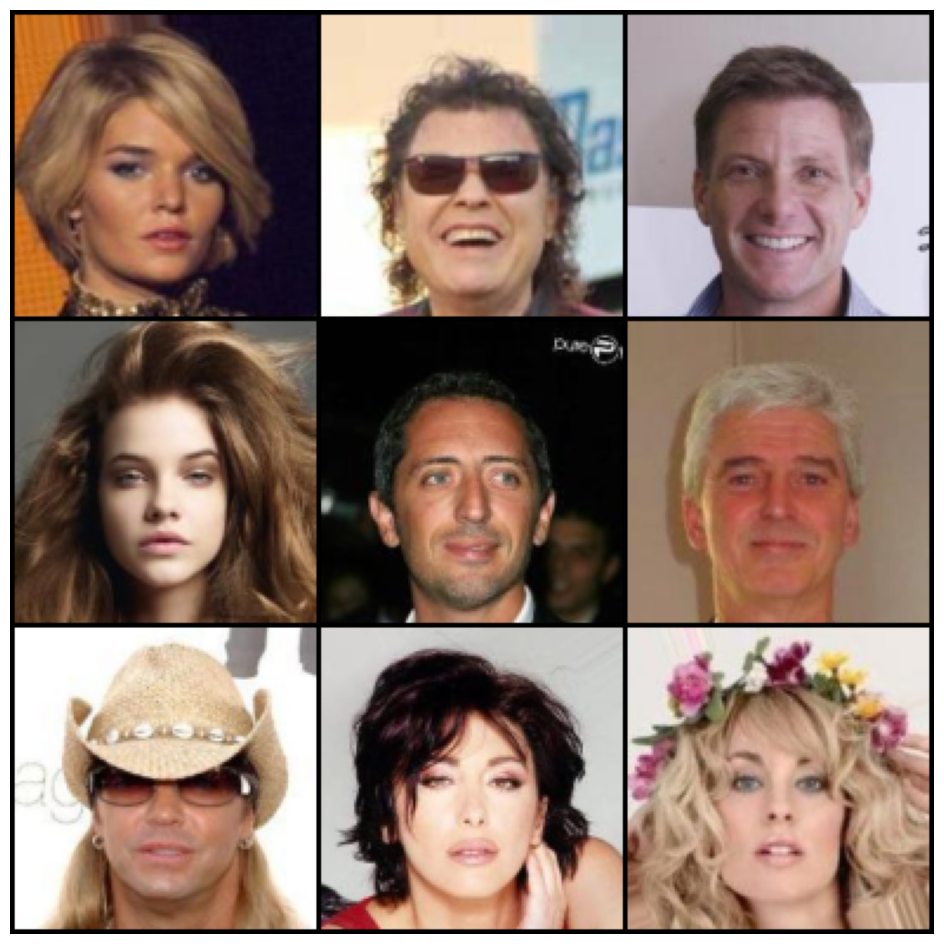

In [5]:
visualize_celeba_examples(dataloader=celeba_loader, num_examples=9, img_size=128,  fig_size=(12,12))

The training was carried out separately in `src/main_train_celebA.py`. This is without a doubt the most demanding dataset used in the project so I needed to use `num_workers = 8` to take advantage of the CPU sobprocesses and store many more batches in the GPU at a time. PyTorch sometimes have some problems and crashes when defining `num_woekers > 0` in notebooks so for making sure that the training was developed without errors and as fast as possible I ran the separate program.

The parameters used are a batch size of $64$, a learning rate of $\alpha = 3 \cdot 10^{-4}$ and a maximum $\beta = 2$. Regarding the model dimensions I used dimensions 2048, 1024 and 512 for hidden layers and a 256-D latent space. Training lasted 2 hours and 50 minutes on a Nvidia RTX 4070. In the next cell we load the trained model parameters

In [6]:
model = VAE(**celeba_configs, f_out='tanh').to(device)
model.load_state_dict(torch.load(r"C:\Users\Ángel\Documents\GitHub\vae-project\src\vae_celeba_trained2.pth", map_location= device))

<All keys matched successfully>

### Test

In [7]:
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=49152, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
    (hidden2mu): Linear(in_features=512, out_features=256, bias=True)
    (hidden2logvar): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): ReLU()
    )
    (hidden2out): Linear(in_features=2048, out_features=49152, bias=True)
  )
)

We visualize one test image reconstruction to see how the model does on new data.

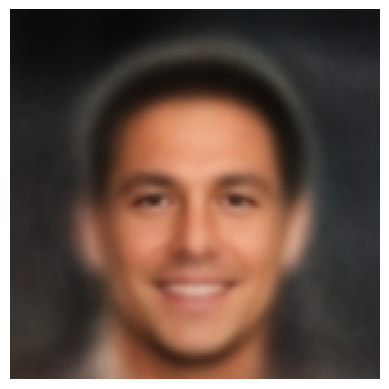

In [8]:
img_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\test\000012.jpg"
image_reconstruction(img_root, model, device)

And the original image is

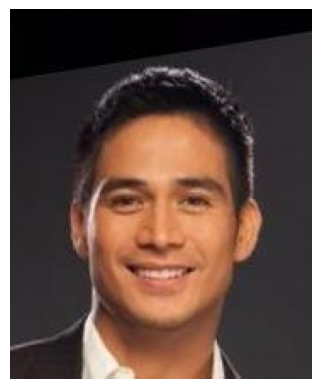

In [9]:
image = Image.open(img_root).convert('RGB')
plt.imshow(image)
plt.axis('off')
plt.show()

As we can see the VAE reconstructs with a lot of blurriness but the majority of facial datails are conserved, this is because these features have been learned in the latent space.

### Image Attibutes Filter

CelebA comes together with a `.csv` file which has one hot labels for many features and every image. We will first read and select some of those features using `Pandas`.

In [10]:
df = pd.read_csv(r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\list_attr_celeba.csv", sep = ',')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [11]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [12]:
columns = ['Smiling', 'Male', 'Blond_Hair', 'No_Beard', 'Young', 'Eyeglasses']
df = df.set_index('image_id')
df = df[columns]
df.head()

,Smiling,Male,Blond_Hair,No_Beard,Young,Eyeglasses
image_id,,,,,,
000001.jpg,1,-1,-1,1,1,-1
000002.jpg,1,-1,-1,1,1,-1
000003.jpg,-1,1,-1,1,1,-1
000004.jpg,-1,-1,-1,1,1,-1
000005.jpg,-1,-1,-1,1,1,-1


In [13]:
df.rename(columns={'No_Beard': 'Beard'}, inplace = True) 
df['Beard'] = df['Beard']*(-1)
df.head()

,Smiling,Male,Blond_Hair,Beard,Young,Eyeglasses
image_id,,,,,,
000001.jpg,1,-1,-1,-1,1,-1
000002.jpg,1,-1,-1,-1,1,-1
000003.jpg,-1,1,-1,-1,1,-1
000004.jpg,-1,-1,-1,-1,1,-1
000005.jpg,-1,-1,-1,-1,1,-1


Now we will try to get the average latent vector for each attribute value. For example we will get the averages latent directions of images smiling and not doing so. The same will apply to the other features.

In [14]:
root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba"

In [15]:
files_per_attribute = {}

for column in df.columns:
    files_per_attribute[column] = df[df[column] == 1].index.tolist()
    files_per_attribute[f'no_{column}'] = df[df[column] == -1].index.tolist()

In [16]:
loaders = {}

for attribute, files in files_per_attribute.items():
    loaders[attribute] = load_celeba(root, image_files = files)

In [17]:
def encode_latents(dataloader, model, device):
    latents = []

    with torch.no_grad():
        for imgs in dataloader:
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            mu, _ = model.encoder(imgs)
            latents.append(mu)
    
    return torch.cat(latents, dim = 0)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now we get the average latent direction of each facial detail.

In [19]:
latents = {}

for attribute, loader in loaders.items():
    z = encode_latents(loader, model, device)
    mean = z.mean(dim = 0)
    latents[attribute] = mean

We take the difference of related features so we can move from one to the other by multiplying them by a scalar $\alpha$ and adding the result up to the sample latent encoding $z$.

In [20]:
smile_dir = latents['Smiling'] - latents['no_Smiling']
smile_dir.to(device)

male_dir = latents['Male'] - latents['no_Male']
male_dir.to(device)

blond_dir = latents['Blond_Hair'] - latents['no_Blond_Hair']
blond_dir.to(device)

beard_dir = latents['Beard'] - latents['no_Beard']
beard_dir.to(device)

young_dir = latents['Young'] - latents['no_Young']
young_dir.to(device)

eyeglasses_dir = latents['Eyeglasses'] - latents['no_Eyeglasses']
eyeglasses_dir.to(device)

tensor([ 1.2232e-02,  7.7274e-03, -6.8742e-03, -3.2753e-02,  1.0961e-02,
         6.0076e-03,  1.6753e-02, -5.8632e-03,  1.9231e-01, -1.7818e-03,
        -1.6214e-03,  6.2171e-03, -6.5825e-04,  2.7756e-03,  6.1298e-03,
         3.4447e-03, -3.8468e-03, -3.0007e-03,  5.6400e-03, -1.5891e-04,
         3.2459e-03, -8.4810e-03,  3.0727e-03, -5.0643e-04,  5.4761e-03,
         4.2110e-03, -3.0944e-03,  4.9522e-03,  3.5867e-03, -1.0549e-02,
        -7.4648e-03,  8.4261e-03, -3.0097e-03,  2.5091e-03, -9.9261e-03,
         5.2490e-03,  3.2843e-01,  9.4033e-03, -2.6939e-02, -1.9701e-03,
         2.0934e-03,  2.1799e-03, -1.1244e-02, -7.4035e-03,  3.3806e-03,
        -9.8919e-04, -3.0286e-01, -5.6758e-03, -2.6241e-04,  1.0425e-02,
        -3.2187e-03, -1.2572e-02,  1.0509e-02, -9.5368e-03, -5.4202e-03,
         5.8625e-03, -5.2375e-03, -3.1308e-03,  8.8659e-02,  1.8233e-02,
         1.7151e-03, -2.6239e-03, -5.0890e-02, -3.7064e-01,  6.5237e-04,
         9.7348e-04,  1.8079e-03, -2.8875e-03,  6.7

Here we have a quick procedure to get an image modified using this latent directions. In this case we transform the man in the previous picture into a woman

In [37]:
img_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\test\000012.jpg"

In [38]:
image = Image.open(img_root).convert("RGB")

# We apply the same loading transformations.
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) 
])

x = transform(image).to(device)
x = x.view(-1)


# We get x through the encoder to get mu and logvar
mu, logvar = model.encoder(x) 

# Using the reparametrization trick and the encoder output we sample a latent vector
std = torch.exp(0.5 * logvar).to(device)
eps = torch.randn_like(std).to(device)
z = mu + eps * std
z = z.to(device)

In [42]:
# Alpha will be our feature controller
alpha = torch.ones_like(male_dir)*-2
alpha = alpha.to(device)

In [43]:
z_modified = z + alpha * male_dir

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

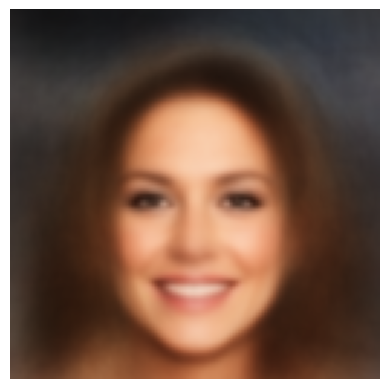

In [44]:
# Visualization

x_hat = model.decoder(z_modified)

x_hat = denormalize(x_hat)

with torch.no_grad():
    x_hat = x_hat.view(3, 128, 128).cpu().numpy()

x_hat = np.transpose(x_hat, (1,2,0))

plt.imshow(x_hat)
plt.axis('off')

And the statistical magic happens, we have turned our first man into a woman.

The fun thing is being able to control different learnt aspects at the same time. Because of that I have created a `Gradio` Interface were there are sliders for each feature's $\alpha$. The iterface use the function `latent_interpolation` to control the sliders and get the original and modfied representations. You can find this function in `src/utils.py`. 

In [26]:
img_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\test\000012.jpg"

In [27]:
directions = {
    "Blond": blond_dir,
    "Smile": smile_dir,
    "Male": male_dir,
    "Eyeglasses": eyeglasses_dir,
    "Young": young_dir,
    "Beard": beard_dir
}

`Gradio` only allows its own interface elements to be part of the function inputs which we are loading with `gr.Interface`. An intelligent solution to this is to define a wrapper previous to the interface definition.

In [28]:
def latent_interpolation_wrapper(blond, smile, male, glasses, young, beard):
    return latent_interpolation(model, device, directions, img_root, blond, smile, male, glasses, young, beard)

In [29]:
import gradio as gr

demo = gr.Interface(
    fn = latent_interpolation_wrapper,
    inputs=[
        gr.Slider(-3, 3, step=0.1, label = "Blond", value=0),
        gr.Slider(-3, 3, step=0.1, label = "Smile", value=0),
        gr.Slider(-3, 3, step=0.1, label = "Male",value=0),
        gr.Slider(-3, 3, step=0.1, label = "Glasses", value=0),
        gr.Slider(-3, 3, step=0.1, label = "Young", value=0),
        gr.Slider(-3, 3, step=0.1, label = "Beard", value=0)
    ],
    outputs=[
        gr.Image(label="Original reconstruction (all alphas set to 0)"),
        gr.Image(label="Modified reconstruction")
    ],
    live=True, 
    title="VAE Facial Attributes Latent Interpolation"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


We have turned the first picture into a blonde guy with glasses and a little beard.

IMPORTANT: This element is static in github. Hugging Face Space linkt o access the slider: 